In [1]:
# Dependencies
import tweepy
import json
import numpy as np
import pandas as pd
from pprint import pprint
from config import consumer_key, consumer_secret, access_token, access_token_secret

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import time


In [2]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [3]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [4]:
# Target Search Term
target_terms = ("@BBC", "@CBS", "@CNN",
                "@Fox", "@nytimes")


In [5]:
#Dictionnary to hold sentiment analyzer values
sentiments = []

# Loop through all target users
for target in target_terms: 

    # Variables for holding sentiments
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []
    
     # Set a counter to count the of tweet between each tweet 
    counter = 1   
    
    # Loop through 5 times (total of 100 tweets per target)
    for x in range(5):
        #print (target)
        # Run search around each tweet
        public_tweets = api.user_timeline(target, page= x+1)
        
        for tweet in public_tweets:
       
            source = target
            tweetext = tweet["text"]
            compound = analyzer.polarity_scores(tweet["text"])["compound"]
            pos = analyzer.polarity_scores(tweet["text"])["pos"]
            neu = analyzer.polarity_scores(tweet["text"])["neu"]
            neg = analyzer.polarity_scores(tweet["text"])["neg"]
            tweets_ago = counter
       
            #Populate values of the tweet sentimemt analysis in the dictionary
            sentiments.append({
                           "Source":source,
                           "Date": tweet["created_at"], 
                           "Compound": compound,
                           "Positive": pos,
                           "Negative": neu,
                           "Neutral": neg,
                           "Tweets Ago": counter,
                            "Tweet Text": tweetext })
        
             # Add to counter 
            counter = counter + 1
        

In [6]:
# Convert sentiments to DataFrame
sentiments_pd = pd.DataFrame.from_dict(sentiments)
sentiments_pd=sentiments_pd[["Source","Tweet Text", "Date","Compound","Positive","Neutral","Negative","Tweets Ago"]]
#sentiments_pd.head()


In [7]:
# Save the data in a CSV file
sentiments_pd.to_csv('TwitterMediaSentiment.csv', index = False, encoding='utf-8')

In [8]:
#The first plot : scatter plot of sentiments of the last 100 tweets sent out by each news organization,
# Create a pivot table to display data to use for the scatter plot
df_mean = sentiments_pd.groupby(["Source"]).mean()["Compound"]
sentiments_pd_mean = df_mean.reset_index()
sentiments_pd_mean = sentiments_pd.pivot(index="Tweets Ago", columns="Source")["Compound"]
#sentiments_pd_mean.head()

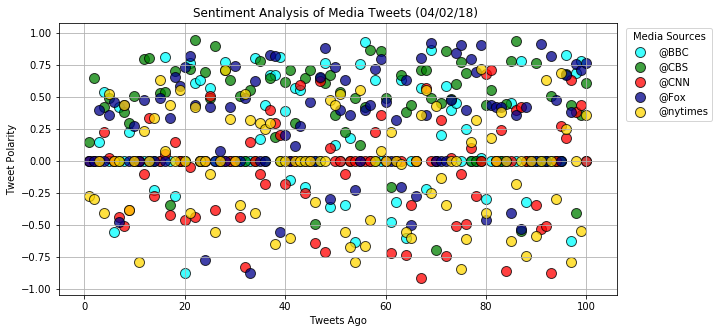

In [12]:
# Create the scatter plot

plt.figure(figsize=(10,5))

plt.scatter(sentiments_pd_mean.index,sentiments_pd_mean["@BBC"], color='cyan', s=100,marker="o",edgecolors="black",alpha=0.75)
plt.scatter(sentiments_pd_mean.index,sentiments_pd_mean["@CBS"], color='green', s=100,marker="o",edgecolors="black",alpha=0.75)
plt.scatter(sentiments_pd_mean.index,sentiments_pd_mean["@CNN"], color='red', s=100, marker="o",edgecolors="black",alpha=0.75)
plt.scatter(sentiments_pd_mean.index,sentiments_pd_mean["@Fox"], color='darkblue', s=100, marker="o",edgecolors="black",alpha=0.75)
plt.scatter(sentiments_pd_mean.index,sentiments_pd_mean["@nytimes"], color='gold', s=100, marker="o",edgecolors="black",alpha=0.75)

# Setting the title, the y and x labels of the plot
plt.title("Sentiment Analysis of Media Tweets (%s) " % (time.strftime("%x")))
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")

# Set a grid on the plot
plt.grid()

# Set the legend on the plot
plt.legend(title="Media Sources",loc='upper right', bbox_to_anchor=(1.18, 1))

# Save the scatter plot
plt.savefig("MediaSentimentAnalysis.png")
plt.show()

In [13]:
# The second plot: a bar plot visualizing the overall sentiments of the last 100 tweets from each organization. 
# Create a data frame to store data that will be used the display the bar plot
df_mean2 = sentiments_pd.groupby(["Source"]).mean()["Compound"]
df_mean_pd = pd.DataFrame(df_mean2)
#df_mean_pd

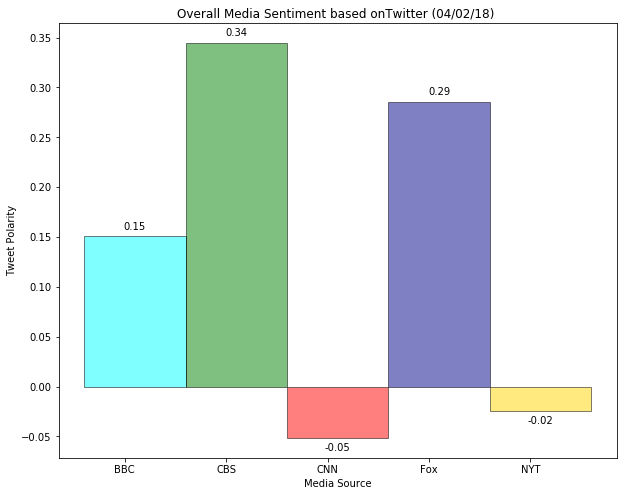

In [11]:
# Creating the bar plot
#f, ax = plt.subplots()

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

# #ax.add_patch(
#      patches.Rectangle(
#          (0.1, 0.1),   # (x,y)
#          0.5,          # width
#          0.5,          # height
#      )
#  )

x_axis = np.arange(len(df_mean_pd))
#my_colors = 'rgbkymc'
my_colors = ['cyan', 'green', 'red', 'darkblue', 'gold']
# Tell matplotlib that we will be making a bar chart
# Users is our y axis and x_axis is, of course, our x axis
# We apply align="edge" to ensure our bars line up with our tick marks
plt.bar(x_axis, df_mean_pd["Compound"], color=my_colors, alpha=0.5, align="edge",edgecolor = 'black',width =1)
tick_locations = [value+0.4 for value in x_axis]
plt.xticks(tick_locations, ["BBC", "CBS", "CNN", "Fox", "NYT"])

# Set x and y limits
#plt.xlim(-0.25, len(x_axis))
#plt.ylim(0, max(df_mean_pd["Compound"])+0.1)

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.2f}".format(y_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.

# Setting the title, the y and x labels of the plot
plt.title("Overall Media Sentiment based onTwitter (%s) " % (time.strftime("%x")))
plt.ylabel("Tweet Polarity")
plt.xlabel("Media Source")

# Save and display the bar chart
plt.savefig("OverallMediaSentiment.png")
plt.show()